### Notebook for testing my code

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
my_path="data"
df=pd.read_csv(f"{my_path}/creditcard.csv")


### Modify Time variable:

In [3]:
df["Hours"] = df["Time"] // 3600

### Some fast visualizations

In [4]:
df.groupby('Class').size()
outlier_fraction = df['Class'].sum()/len(df)
print("proportion of frauds: ", outlier_fraction )
print("number of fraud transactions: ",df['Class'].sum())

proportion of frauds:  0.001727485630620034
number of fraud transactions:  492


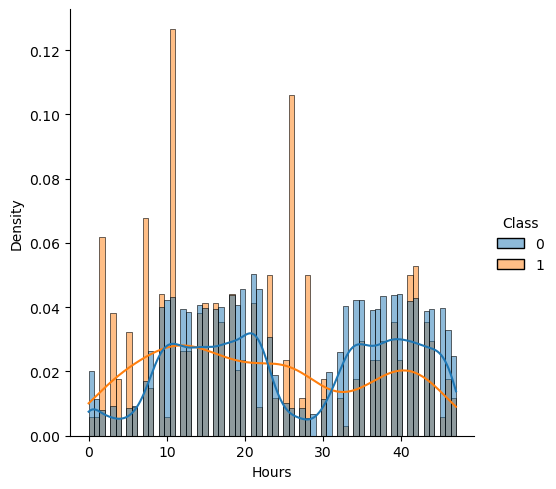

In [5]:
sns.displot(data=df,x='Hours',hue='Class', kde=True,stat='density', common_norm=False)

<Figure size 1000x600 with 0 Axes>

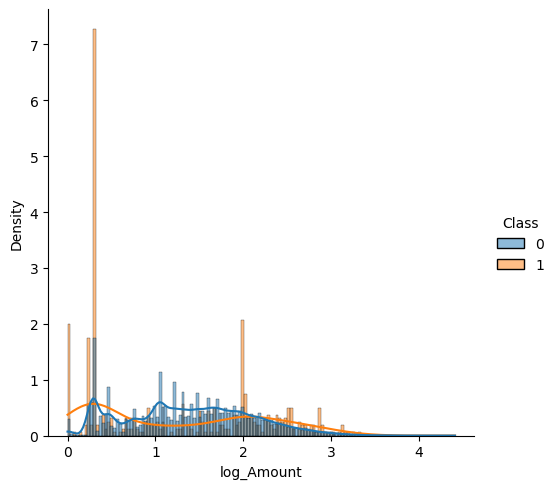

In [6]:
df["log_Amount"] = np.log10(df["Amount"] + 1)
plt.figure(figsize=(10,6))
sns.displot(data=df,x='log_Amount',hue='Class', kde=True,stat='density', common_norm=False)
plt.show()

### Split the data

In [7]:
x=df.drop(columns=["Class","Time","Amount","Hours"])
y=df["Class"]
x_clean=x[y==0]
y_clean=y[y==0]
x_fraud=x[y==1]
y_fraud=y[y==1]
x_train, x_test, y_train, y_test = train_test_split(x_clean,y_clean,test_size=0.2, random_state=1)

In [8]:
x_test = pd.concat([x_test, x_fraud], axis=0)
y_test = pd.concat([y_test, y_fraud], axis=0)

###
For the following we want to predict 1 000 observations like possibly fraudulent transactions, so we use the `pourcent` as the `contamination` parameter in the Isolation Forest model.

In [9]:
predictict_outlier=1000
pourcent= predictict_outlier/len(x_test)
print("proportion of predicted outliers: ", pourcent)

proportion of predicted outliers:  0.01743527155435446


#### Isolation Forest

In [10]:
import importlib
from models import isolation_forest
from utils import evaluate_models
importlib.reload(isolation_forest)
importlib.reload(evaluate_models)
from models.isolation_forest import (
    train_isolation_forest,
    predict_isolation_forest
)     
from utils.evaluate_models import evaluate_model, print_evaluation

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [12]:
#normalize data s+with minmax
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [13]:
model = train_isolation_forest(x_train, contamination=pourcent,n_estimators=100)
y_pred_iso = predict_isolation_forest(model, x_test)
print_evaluation(evaluate_model(y_test, y_pred_iso))

Confusion Matrix:
[[55845  1018]
 [  145   347]]

Classification Report:
Label 0:
  precision: 0.9974
  recall: 0.9821
  f1-score: 0.9897
  support: 56863.0000
Label 1:
  precision: 0.2542
  recall: 0.7053
  f1-score: 0.3737
  support: 492.0000


### SVM

In [14]:
import importlib
from models import svm
from utils import evaluate_models
importlib.reload(svm)
importlib.reload(evaluate_models)
from models.svm import (
    train_one_class_svm,
    predict_one_class_svm,
    train_sgd_one_class_svm,
    predict_sgd_one_class_svm
) 

### SVM one class 

In [15]:
model = train_one_class_svm(x_train, nu=0.01, kernel='rbf', gamma='scale')
y_pred_svm = predict_one_class_svm(model, x_test)
print_evaluation(evaluate_model(y_test, y_pred_svm))

Confusion Matrix:
[[56296   567]
 [  107   385]]

Classification Report:
Label 0:
  precision: 0.9981
  recall: 0.9900
  f1-score: 0.9940
  support: 56863.0000
Label 1:
  precision: 0.4044
  recall: 0.7825
  f1-score: 0.5332
  support: 492.0000


### SGD One Class SVM

In [16]:
model = train_sgd_one_class_svm(x_train, nu=0.01)
y_pred_svm_sgd = predict_sgd_one_class_svm(model, x_test)
print_evaluation(evaluate_model(y_test, y_pred_svm_sgd))

Confusion Matrix:
[[56530   333]
 [  110   382]]

Classification Report:
Label 0:
  precision: 0.9981
  recall: 0.9941
  f1-score: 0.9961
  support: 56863.0000
Label 1:
  precision: 0.5343
  recall: 0.7764
  f1-score: 0.6330
  support: 492.0000


### Local outlier factor

In [17]:
import importlib
from models import local_outiers_factor
from utils import evaluate_models
importlib.reload(local_outiers_factor)
importlib.reload(evaluate_models)
from models.local_outiers_factor import (
    train_local_outlier_factor,
    predict_local_outliers_factor
) 

In [18]:
model=train_local_outlier_factor(x_train, n_neighbors=20, contamination=pourcent, novelty=False)
y_pred_lof = predict_local_outliers_factor(model, x_test) 
print_evaluation(evaluate_model(y_test, y_pred_lof))


c:\Users\lucas\anaconda3\envs\fraud-detection\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


Confusion Matrix:
[[55893   970]
 [  462    30]]

Classification Report:
Label 0:
  precision: 0.9918
  recall: 0.9829
  f1-score: 0.9874
  support: 56863.0000
Label 1:
  precision: 0.0300
  recall: 0.0610
  f1-score: 0.0402
  support: 492.0000


### Auto Encoder


In [19]:
X_train, X_validate = train_test_split(x_train, 
                                       test_size=0.20, 
                                       random_state=42)

In [20]:
import torch
x_train_tensor = torch.tensor(X_train, dtype=torch.float32)
x_val_tensor   = torch.tensor(X_validate, dtype=torch.float32)

In [21]:
import models.auto_encoder as auto_encoder
importlib.reload(auto_encoder)
from models.auto_encoder import (
    Autoencoder,
    fit
)

In [22]:
model = Autoencoder(input_dim=x_train_tensor.shape[1], encoding_dim=2)
loss_fn = torch.nn.MSELoss("mean") 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

c:\Users\lucas\anaconda3\envs\fraud-detection\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


100%|██████████| 711/711 [00:07<00:00, 101.48it/s]


Epoch 1/100 | Train 0.019618 | Val 0.002922 | Best 0.002922


100%|██████████| 711/711 [00:05<00:00, 124.14it/s]


Epoch 2/100 | Train 0.002622 | Val 0.002026 | Best 0.002026


100%|██████████| 711/711 [00:05<00:00, 119.52it/s]


Epoch 3/100 | Train 0.002019 | Val 0.001993 | Best 0.001993


100%|██████████| 711/711 [00:05<00:00, 119.06it/s]


Epoch 4/100 | Train 0.001986 | Val 0.001950 | Best 0.001950


100%|██████████| 711/711 [00:06<00:00, 117.10it/s]


Epoch 5/100 | Train 0.001938 | Val 0.001872 | Best 0.001872


100%|██████████| 711/711 [00:06<00:00, 115.06it/s]


Epoch 6/100 | Train 0.001829 | Val 0.001778 | Best 0.001778


100%|██████████| 711/711 [00:05<00:00, 121.85it/s]


Epoch 7/100 | Train 0.001777 | Val 0.001750 | Best 0.001750


100%|██████████| 711/711 [00:05<00:00, 119.46it/s]


Epoch 8/100 | Train 0.001756 | Val 0.001741 | Best 0.001741


100%|██████████| 711/711 [00:06<00:00, 117.53it/s]


Epoch 9/100 | Train 0.001748 | Val 0.001729 | Best 0.001729


100%|██████████| 711/711 [00:06<00:00, 111.07it/s]


Epoch 10/100 | Train 0.001744 | Val 0.001730 | Best 0.001729


100%|██████████| 711/711 [00:05<00:00, 119.02it/s]


Epoch 11/100 | Train 0.001743 | Val 0.001736 | Best 0.001729


100%|██████████| 711/711 [00:06<00:00, 115.29it/s]


Epoch 12/100 | Train 0.001743 | Val 0.001729 | Best 0.001729


100%|██████████| 711/711 [00:06<00:00, 114.77it/s]


Epoch 13/100 | Train 0.001743 | Val 0.001727 | Best 0.001727


100%|██████████| 711/711 [00:05<00:00, 119.60it/s]


Epoch 14/100 | Train 0.001743 | Val 0.001730 | Best 0.001727


100%|██████████| 711/711 [00:05<00:00, 121.30it/s]


Epoch 15/100 | Train 0.001742 | Val 0.001732 | Best 0.001727


100%|██████████| 711/711 [00:06<00:00, 116.53it/s]


Epoch 16/100 | Train 0.001742 | Val 0.001729 | Best 0.001727


100%|██████████| 711/711 [00:06<00:00, 115.85it/s]


Epoch 17/100 | Train 0.001741 | Val 0.001726 | Best 0.001727


100%|██████████| 711/711 [00:06<00:00, 116.21it/s]


Epoch 18/100 | Train 0.001741 | Val 0.001728 | Best 0.001727


100%|██████████| 711/711 [00:05<00:00, 121.43it/s]


Epoch 19/100 | Train 0.001740 | Val 0.001726 | Best 0.001727


100%|██████████| 711/711 [00:03<00:00, 179.07it/s]


Epoch 20/100 | Train 0.001739 | Val 0.001728 | Best 0.001727


100%|██████████| 711/711 [00:06<00:00, 110.07it/s]


Epoch 21/100 | Train 0.001737 | Val 0.001722 | Best 0.001722


100%|██████████| 711/711 [00:06<00:00, 115.05it/s]


Epoch 22/100 | Train 0.001735 | Val 0.001718 | Best 0.001718


100%|██████████| 711/711 [00:05<00:00, 119.09it/s]


Epoch 23/100 | Train 0.001732 | Val 0.001723 | Best 0.001718


100%|██████████| 711/711 [00:06<00:00, 118.15it/s]


Epoch 24/100 | Train 0.001726 | Val 0.001708 | Best 0.001708


100%|██████████| 711/711 [00:05<00:00, 128.43it/s]


Epoch 25/100 | Train 0.001714 | Val 0.001696 | Best 0.001696


100%|██████████| 711/711 [00:05<00:00, 118.87it/s]


Epoch 26/100 | Train 0.001703 | Val 0.001688 | Best 0.001688


100%|██████████| 711/711 [00:06<00:00, 107.07it/s]


Epoch 27/100 | Train 0.001696 | Val 0.001679 | Best 0.001679


100%|██████████| 711/711 [00:07<00:00, 98.44it/s] 


Epoch 28/100 | Train 0.001691 | Val 0.001678 | Best 0.001678


100%|██████████| 711/711 [00:05<00:00, 118.79it/s]


Epoch 29/100 | Train 0.001686 | Val 0.001672 | Best 0.001672


100%|██████████| 711/711 [00:05<00:00, 129.48it/s]


Epoch 30/100 | Train 0.001682 | Val 0.001668 | Best 0.001668


100%|██████████| 711/711 [00:06<00:00, 113.29it/s]


Epoch 31/100 | Train 0.001679 | Val 0.001667 | Best 0.001667


100%|██████████| 711/711 [00:06<00:00, 109.01it/s]


Epoch 32/100 | Train 0.001676 | Val 0.001664 | Best 0.001664


100%|██████████| 711/711 [00:06<00:00, 112.71it/s]


Epoch 33/100 | Train 0.001673 | Val 0.001659 | Best 0.001659


100%|██████████| 711/711 [00:05<00:00, 123.03it/s]


Epoch 34/100 | Train 0.001671 | Val 0.001661 | Best 0.001659


100%|██████████| 711/711 [00:06<00:00, 105.30it/s]


Epoch 35/100 | Train 0.001669 | Val 0.001656 | Best 0.001656


100%|██████████| 711/711 [00:07<00:00, 95.59it/s] 


Epoch 36/100 | Train 0.001667 | Val 0.001657 | Best 0.001656


100%|██████████| 711/711 [00:04<00:00, 156.07it/s]


Epoch 37/100 | Train 0.001665 | Val 0.001653 | Best 0.001653


100%|██████████| 711/711 [00:06<00:00, 101.60it/s]


Epoch 38/100 | Train 0.001664 | Val 0.001652 | Best 0.001653


100%|██████████| 711/711 [00:07<00:00, 96.51it/s] 


Epoch 39/100 | Train 0.001663 | Val 0.001655 | Best 0.001653


100%|██████████| 711/711 [00:07<00:00, 97.91it/s] 


Epoch 40/100 | Train 0.001662 | Val 0.001651 | Best 0.001651


100%|██████████| 711/711 [00:06<00:00, 107.23it/s]


Epoch 41/100 | Train 0.001661 | Val 0.001651 | Best 0.001651


100%|██████████| 711/711 [00:06<00:00, 104.56it/s]


Epoch 42/100 | Train 0.001660 | Val 0.001650 | Best 0.001650


100%|██████████| 711/711 [00:06<00:00, 105.00it/s]


Epoch 43/100 | Train 0.001659 | Val 0.001645 | Best 0.001645


100%|██████████| 711/711 [00:08<00:00, 83.36it/s] 


Epoch 44/100 | Train 0.001659 | Val 0.001647 | Best 0.001645


100%|██████████| 711/711 [00:06<00:00, 114.80it/s]


Epoch 45/100 | Train 0.001658 | Val 0.001646 | Best 0.001645


100%|██████████| 711/711 [00:06<00:00, 103.26it/s]


Epoch 46/100 | Train 0.001657 | Val 0.001647 | Best 0.001645


100%|██████████| 711/711 [00:04<00:00, 152.77it/s]


Epoch 47/100 | Train 0.001656 | Val 0.001644 | Best 0.001644


100%|██████████| 711/711 [00:04<00:00, 153.71it/s]


Epoch 48/100 | Train 0.001654 | Val 0.001643 | Best 0.001643


100%|██████████| 711/711 [00:03<00:00, 231.59it/s]


Epoch 49/100 | Train 0.001652 | Val 0.001637 | Best 0.001637


100%|██████████| 711/711 [00:03<00:00, 231.17it/s]


Epoch 50/100 | Train 0.001649 | Val 0.001638 | Best 0.001637


100%|██████████| 711/711 [00:06<00:00, 112.44it/s]


Epoch 51/100 | Train 0.001646 | Val 0.001636 | Best 0.001637


100%|██████████| 711/711 [00:05<00:00, 118.69it/s]


Epoch 52/100 | Train 0.001645 | Val 0.001642 | Best 0.001637


100%|██████████| 711/711 [00:06<00:00, 104.47it/s]


Epoch 53/100 | Train 0.001644 | Val 0.001634 | Best 0.001634


100%|██████████| 711/711 [00:06<00:00, 105.69it/s]


Epoch 54/100 | Train 0.001643 | Val 0.001633 | Best 0.001633


100%|██████████| 711/711 [00:06<00:00, 112.39it/s]


Epoch 55/100 | Train 0.001643 | Val 0.001634 | Best 0.001633


100%|██████████| 711/711 [00:06<00:00, 102.90it/s]


Epoch 56/100 | Train 0.001642 | Val 0.001640 | Best 0.001633


100%|██████████| 711/711 [00:05<00:00, 122.01it/s]


Epoch 57/100 | Train 0.001642 | Val 0.001633 | Best 0.001633


100%|██████████| 711/711 [00:06<00:00, 116.22it/s]


Epoch 58/100 | Train 0.001642 | Val 0.001630 | Best 0.001630


100%|██████████| 711/711 [00:05<00:00, 125.81it/s]


Epoch 59/100 | Train 0.001642 | Val 0.001631 | Best 0.001630


100%|██████████| 711/711 [00:05<00:00, 125.06it/s]


Epoch 60/100 | Train 0.001641 | Val 0.001629 | Best 0.001629


100%|██████████| 711/711 [00:06<00:00, 117.17it/s]


Epoch 61/100 | Train 0.001640 | Val 0.001632 | Best 0.001629


100%|██████████| 711/711 [00:06<00:00, 110.51it/s]


Epoch 62/100 | Train 0.001640 | Val 0.001632 | Best 0.001629


100%|██████████| 711/711 [00:06<00:00, 112.44it/s]


Epoch 63/100 | Train 0.001640 | Val 0.001632 | Best 0.001629


100%|██████████| 711/711 [00:06<00:00, 112.24it/s]


Epoch 64/100 | Train 0.001639 | Val 0.001629 | Best 0.001629


100%|██████████| 711/711 [00:05<00:00, 118.91it/s]


Epoch 65/100 | Train 0.001638 | Val 0.001630 | Best 0.001629


100%|██████████| 711/711 [00:06<00:00, 114.03it/s]


Epoch 66/100 | Train 0.001639 | Val 0.001627 | Best 0.001627


100%|██████████| 711/711 [00:05<00:00, 122.75it/s]


Epoch 67/100 | Train 0.001638 | Val 0.001629 | Best 0.001627


100%|██████████| 711/711 [00:05<00:00, 121.40it/s]


Epoch 68/100 | Train 0.001638 | Val 0.001629 | Best 0.001627


100%|██████████| 711/711 [00:06<00:00, 117.47it/s]


Epoch 69/100 | Train 0.001637 | Val 0.001629 | Best 0.001627


100%|██████████| 711/711 [00:05<00:00, 119.42it/s]


Epoch 70/100 | Train 0.001637 | Val 0.001630 | Best 0.001627


100%|██████████| 711/711 [00:05<00:00, 125.45it/s]


Epoch 71/100 | Train 0.001637 | Val 0.001628 | Best 0.001627


100%|██████████| 711/711 [00:05<00:00, 121.59it/s]


Epoch 72/100 | Train 0.001636 | Val 0.001627 | Best 0.001627


100%|██████████| 711/711 [00:05<00:00, 120.20it/s]


Epoch 73/100 | Train 0.001635 | Val 0.001627 | Best 0.001627


100%|██████████| 711/711 [00:05<00:00, 120.10it/s]


Epoch 74/100 | Train 0.001634 | Val 0.001627 | Best 0.001627


100%|██████████| 711/711 [00:05<00:00, 123.07it/s]


Epoch 75/100 | Train 0.001634 | Val 0.001627 | Best 0.001627


100%|██████████| 711/711 [00:06<00:00, 116.89it/s]


Epoch 76/100 | Train 0.001633 | Val 0.001625 | Best 0.001625


100%|██████████| 711/711 [00:05<00:00, 133.25it/s]


Epoch 77/100 | Train 0.001632 | Val 0.001626 | Best 0.001625


100%|██████████| 711/711 [00:06<00:00, 114.92it/s]


Epoch 78/100 | Train 0.001631 | Val 0.001623 | Best 0.001623


100%|██████████| 711/711 [00:06<00:00, 110.32it/s]


Epoch 79/100 | Train 0.001630 | Val 0.001621 | Best 0.001621


100%|██████████| 711/711 [00:06<00:00, 109.65it/s]


Epoch 80/100 | Train 0.001628 | Val 0.001618 | Best 0.001618


100%|██████████| 711/711 [00:04<00:00, 172.17it/s]


Epoch 81/100 | Train 0.001626 | Val 0.001619 | Best 0.001618


100%|██████████| 711/711 [00:06<00:00, 115.36it/s]


Epoch 82/100 | Train 0.001624 | Val 0.001614 | Best 0.001614


100%|██████████| 711/711 [00:03<00:00, 201.99it/s]


Epoch 83/100 | Train 0.001623 | Val 0.001613 | Best 0.001613


100%|██████████| 711/711 [00:01<00:00, 359.49it/s]


Epoch 84/100 | Train 0.001621 | Val 0.001618 | Best 0.001613


100%|██████████| 711/711 [00:01<00:00, 469.17it/s]


Epoch 85/100 | Train 0.001619 | Val 0.001613 | Best 0.001613


100%|██████████| 711/711 [00:01<00:00, 441.99it/s]


Epoch 86/100 | Train 0.001617 | Val 0.001608 | Best 0.001608


100%|██████████| 711/711 [00:01<00:00, 456.11it/s]


Epoch 87/100 | Train 0.001615 | Val 0.001608 | Best 0.001608


100%|██████████| 711/711 [00:01<00:00, 422.28it/s]


Epoch 88/100 | Train 0.001612 | Val 0.001604 | Best 0.001604


100%|██████████| 711/711 [00:01<00:00, 419.33it/s]


Epoch 89/100 | Train 0.001610 | Val 0.001599 | Best 0.001599


100%|██████████| 711/711 [00:01<00:00, 527.54it/s]


Epoch 90/100 | Train 0.001608 | Val 0.001602 | Best 0.001599


100%|██████████| 711/711 [00:01<00:00, 517.50it/s]


Epoch 91/100 | Train 0.001606 | Val 0.001600 | Best 0.001599


100%|██████████| 711/711 [00:01<00:00, 450.21it/s]


Epoch 92/100 | Train 0.001603 | Val 0.001592 | Best 0.001592


100%|██████████| 711/711 [00:03<00:00, 211.81it/s]


Epoch 93/100 | Train 0.001601 | Val 0.001591 | Best 0.001591


100%|██████████| 711/711 [00:01<00:00, 384.60it/s]


Epoch 94/100 | Train 0.001599 | Val 0.001591 | Best 0.001591


100%|██████████| 711/711 [00:02<00:00, 334.68it/s]


Epoch 95/100 | Train 0.001597 | Val 0.001586 | Best 0.001586


100%|██████████| 711/711 [00:01<00:00, 357.66it/s]


Epoch 96/100 | Train 0.001595 | Val 0.001583 | Best 0.001583


100%|██████████| 711/711 [00:01<00:00, 501.79it/s]


Epoch 97/100 | Train 0.001593 | Val 0.001584 | Best 0.001583


100%|██████████| 711/711 [00:01<00:00, 507.01it/s]


Epoch 98/100 | Train 0.001590 | Val 0.001580 | Best 0.001580


100%|██████████| 711/711 [00:01<00:00, 449.56it/s]


Epoch 99/100 | Train 0.001589 | Val 0.001582 | Best 0.001580


100%|██████████| 711/711 [00:01<00:00, 468.15it/s]


Epoch 100/100 | Train 0.001587 | Val 0.001576 | Best 0.001576


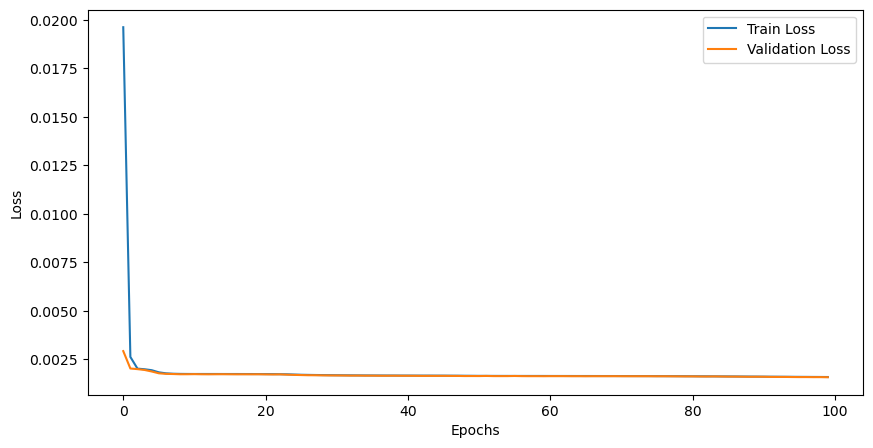

In [23]:
fit(
    model,
    loss_fn,
    optimizer,
    x_train_tensor,
    x_val_tensor,
    epochs=100,
    batch_size=256
)

In [24]:
model.eval()
with torch.no_grad():
    x_val_hat = model(x_val_tensor.to(next(model.parameters()).device)).cpu()
mse_val = ((x_val_hat - x_val_tensor)**2).mean(dim=1).numpy()
threshold = np.quantile(mse_val, 0.989)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
with torch.no_grad():
    x_test_hat = model(x_test_tensor.to(next(model.parameters()).device)).cpu()
mse_test = ((x_test_hat - x_test_tensor)**2).mean(dim=1).numpy()
y_pred = (mse_test > threshold).astype(int)   # 1 = anomalie

In [25]:
confusion_matrix = evaluate_model(y_test, y_pred)
print_evaluation(confusion_matrix)


Confusion Matrix:
[[56179   684]
 [   85   407]]

Classification Report:
Label 0:
  precision: 0.9985
  recall: 0.9880
  f1-score: 0.9932
  support: 56863.0000
Label 1:
  precision: 0.3731
  recall: 0.8272
  f1-score: 0.5142
  support: 492.0000


### Resume of the results

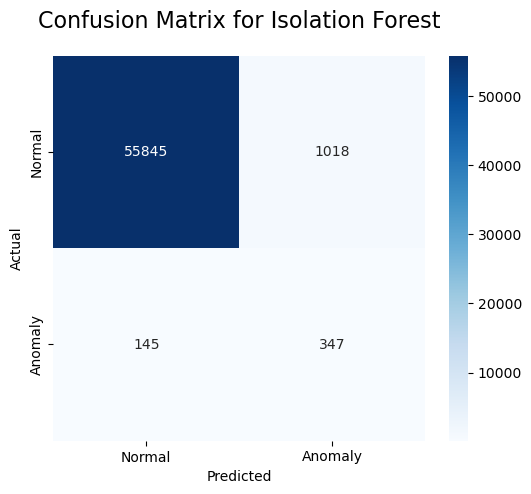

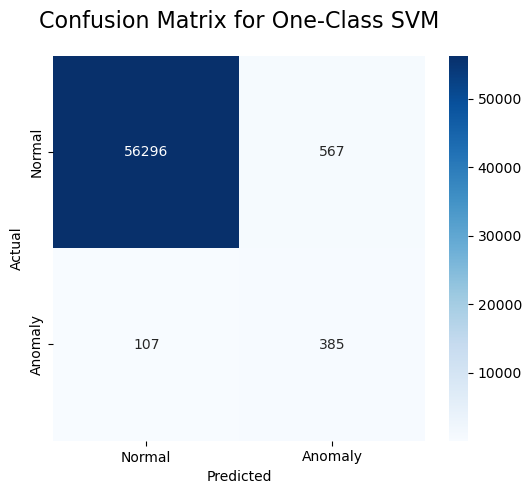

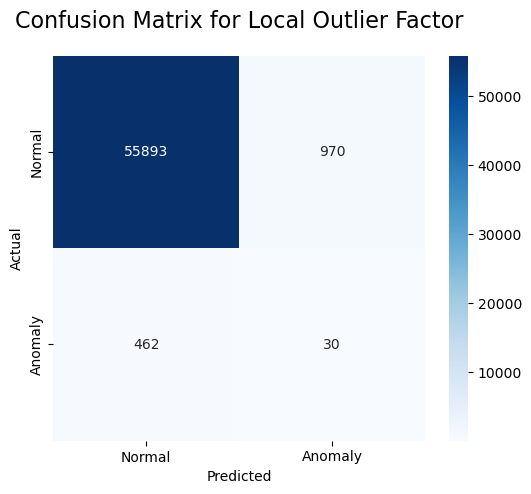

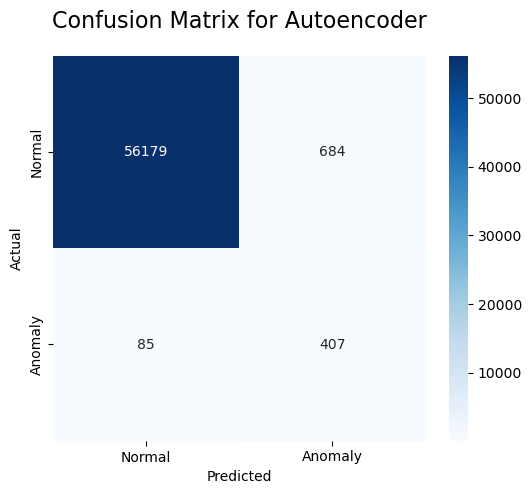

In [26]:
import utils.evaluate_models as evaluate_models
importlib.reload(evaluate_models)
from utils.evaluate_models import evaluate_model, print_evaluation, plot_confusion_matrix
for model_name, y_pred in [("Isolation Forest", y_pred_iso),
                       ("One-Class SVM", y_pred_svm),
                       ("Local Outlier Factor", y_pred_lof),
                       ("Autoencoder", y_pred)]:
    confusion_matrix = evaluate_model(y_test, y_pred)
    plot_confusion_matrix(confusion_matrix["confusion_matrix"], title=model_name)

### Visual representation of Fraud vs Normal transactions in graphs

In [27]:
encoder= model.encoder
encoder.eval()
with torch.no_grad():
    x_test_encoded = encoder(x_test_tensor.to(next(model.parameters()).device)).cpu().numpy()

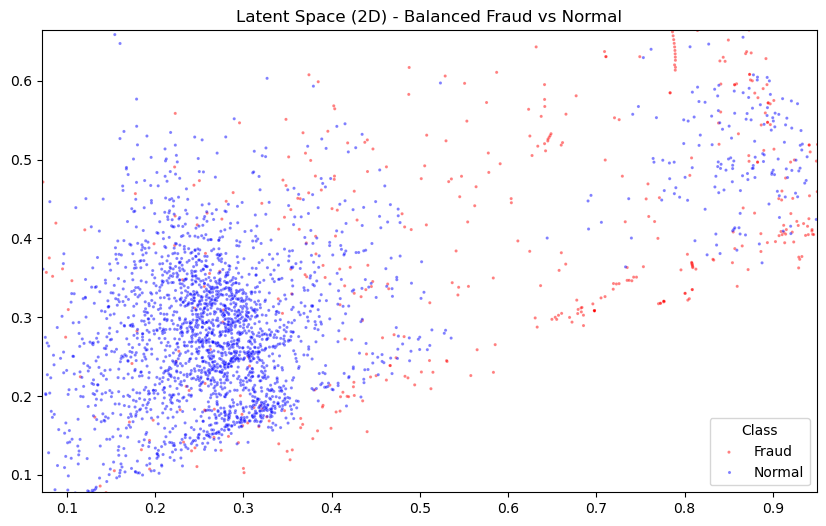

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(42)
y_test_fraud = y_test[y_test == 1]
x_test_encoded_fraud = x_test_encoded[y_test == 1]
x_test_encoded_unsampled = x_test_encoded[y_test == 0][:len(y_test_fraud)*5]
y_test_unsampled = y_test[y_test == 0][:len(y_test_fraud)*5]

y_test_full_unsampled = pd.concat([y_test_fraud, y_test_unsampled], axis=0)
x_test_encoded_full_unsampled = np.vstack([x_test_encoded_fraud, x_test_encoded_unsampled])
#normalize for better visualization
x_test_encoded_full_unsampled = scaler.fit_transform(x_test_encoded_full_unsampled)
X=x_test_encoded_full_unsampled

plt.figure(figsize=(10,6))
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y_test_full_unsampled, palette={0:'blue', 1:'red'}, alpha=0.5,s=5)
# compute bounds (exclude the 5% extremes)
x_min, x_max = np.percentile(X[:, 0], [1, 99])
y_min, y_max = np.percentile(X[:, 1], [1, 99])

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title("Latent Space (2D) - Balanced Fraud vs Normal")
plt.legend(title='Class', labels=['Fraud','Normal'])
plt.show()

